# **Introductory Python for Climate Model Analysis Tutorials**

## **Tutorial 1: Introduction to netCDFs**

Hello and welcome! The goal of this tutorial series is to introduce you to Python for climate model data analysis and visualization. In this first tutorial, we will get aquainted with the most common file format for climate model output, the **netCDF file** and an incredibly useful Python package built for handling them, **Xarray**.

## *What is netCDF?*

The netCDF file format (ending in .nc) is commonly used to store multidemensional (N-dimensional, ND) data in a series of structured arrays. The variables output by a climate model, such as temperature and pressure, need to be stored in an ND format since they typically vary across latitude, longitude, altitude, and time. The graphic below depicts this file structure.

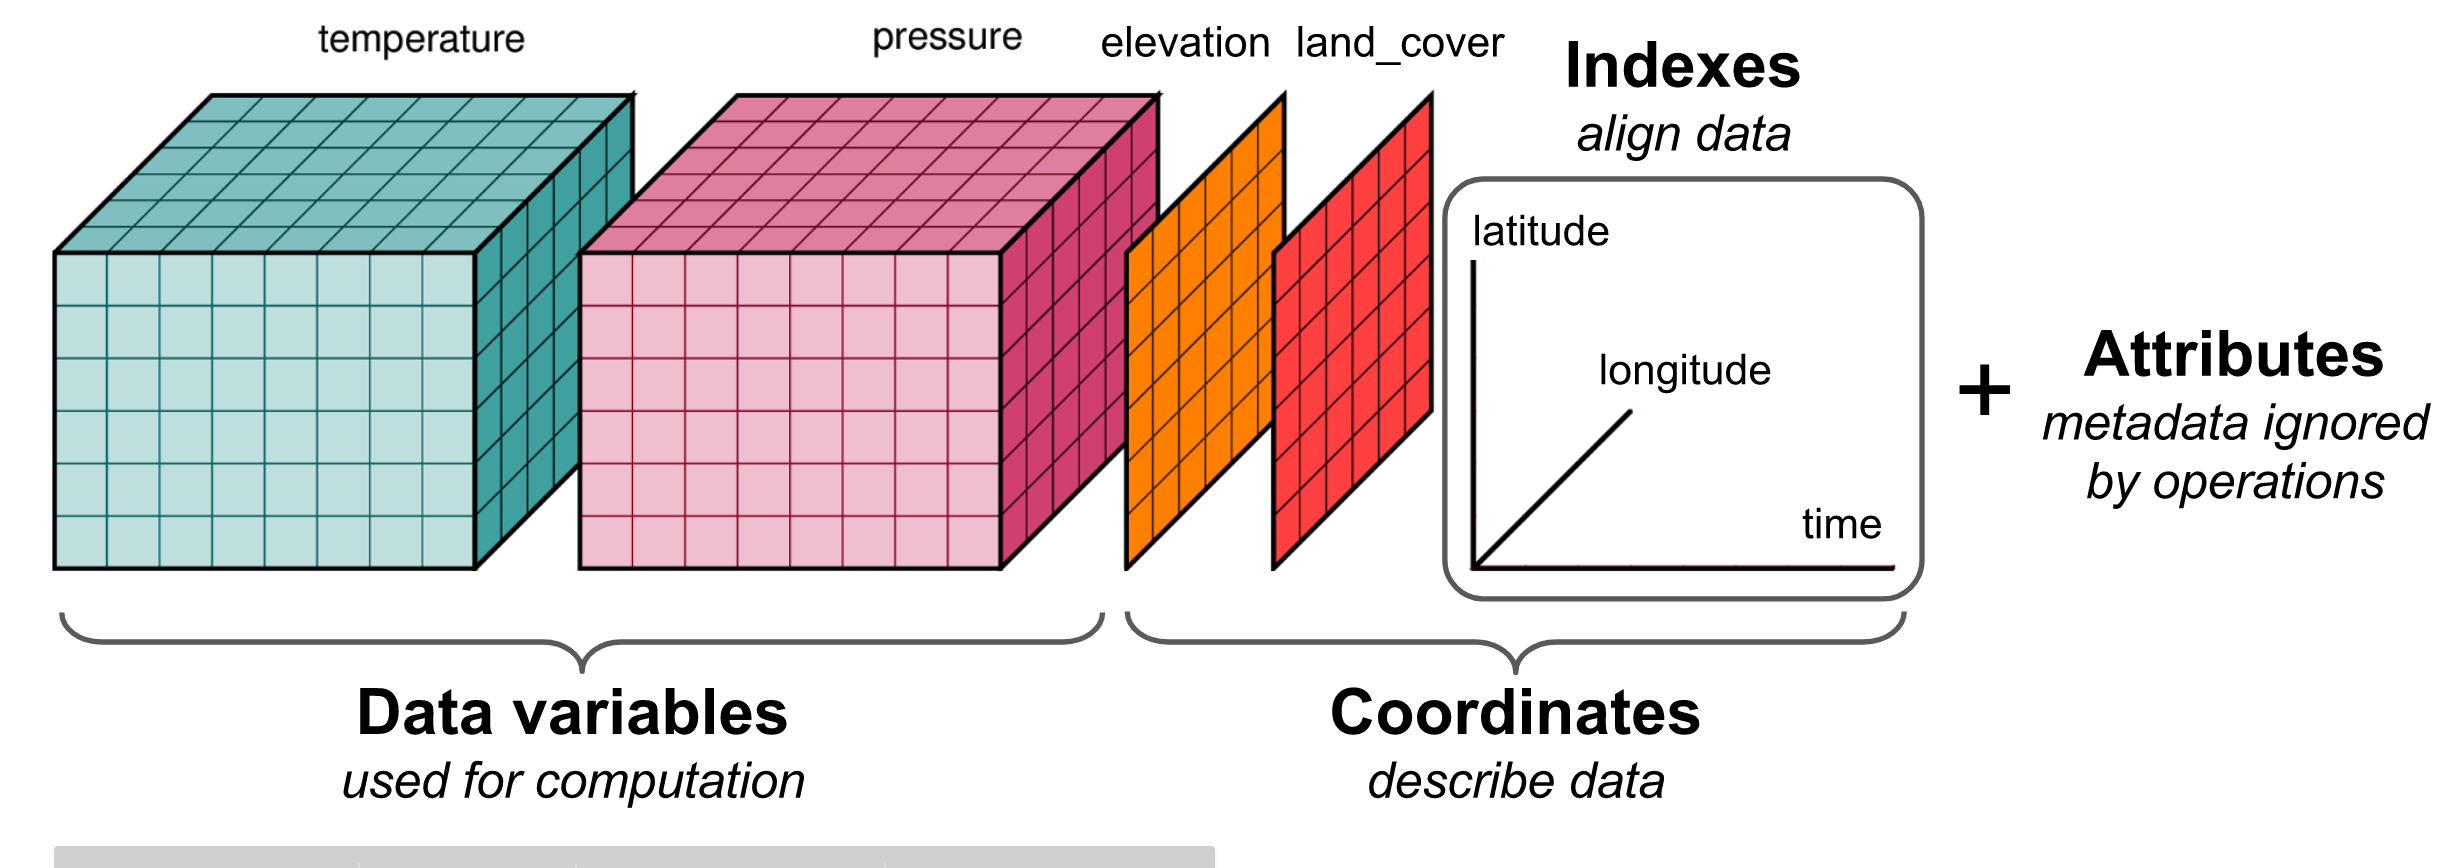

In this tutorial, we will be working with output from the **Community Earth System Model version 2** (CESM2, see documentation [here]('https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2019ms001916')). However, these tools will apply to most climate model and chemistry transport model output, as well as other ND data like satellite retreivals.

## *What is Xarray?*

Xarray is a Python package that allows users to interface with and operate on ND data, such as netCDF files. Let's import Xarray and open an example file.

In [ ]:
import xarray as xr

The following file contains post-processed output of aerosol optical depth (AOD) from the **CESM2-WACCM6** chemistry-climate model. Poke around the Xarray ``Dataset`` to explore its structure.

In [ ]:
ds=xr.open_dataset("/net/fs09/d0/shelkins/Projects/Intro_Tutorials/data/AODVIS_annual_HIST_wa6_ic1.001_1970_2013.nc", engine = "netcdf4")
ds

You probably noticed the following 5 components in the dropdowns. Let's walk through these.
- ``dimensions``
- ``coordinates``
- ``data variables`` 
- ``indexes`` 
- ``attributes``

The ``dimensions`` of a ``Dataset`` are fairly straightforward. Typical ``dimensions`` include latitude, longitude, altitude and time. To display them:

In [ ]:
ds.dims

Our ``Dataset`` has 3 ``dimensions``: 'year', 'lat', 'lon''. We do not have a vertical ``dimension`` because AOD is a single value for the entire atmospheric column.

Let's look at the 'year' dimension.

In [ ]:
ds.year

In [ ]:
#Try looking through the other dimensions here.


The difference between ``dimensions`` and ``coordinates`` can be a bit confusing. For most relevant cases, ``coordinates`` can loosely be thought of as the ticks along a given ``dimension``. A bolded ``coordinate`` is a ``dimension-coordinate``, which are ``coordinates`` that can be used for label-based indexing and alignment.

In [ ]:
ds.coords

``Indexes`` also indicate which ``coordinates`` can be indexed over.

In [ ]:
ds.indexes

``Attributes`` provide the metadata for the ``Dataset``, such as the history of the file and/or citation information. ``Attributes`` are a dictionary of strings and are ignored by any operations performed on the ``Dataset``.

In [ ]:
ds.attrs

One key distinction is that an Xarray ``Dataset`` contains multiple variables, while an Xarray ``DataArray`` contains only a single variable. We can select variables from a ``Dataset`` using the following syntax:

In [ ]:
#select AODVIS DataArray and name it AOD
AOD=ds.AODVIS
AOD

## *Indexing and selecting*

During analysis, you will likely want to select specific regions or time periods from a ``DataArray`` using indexing. There are two main methods for indexing a ``DataArray``: **1.** indexing by name using ``sel`` and ``isel`` or **2.** indexing by position.

Let's say we want to select the first 5 years of ``AOD``. We can index by name using the "year" ``dimension`` and the ``slice`` operator.

In [ ]:
AOD.isel(year=slice(None,5)) #using isel
#or
AOD.sel(year=slice(1970,1974)) #using sel

Alternatively, we can index by position:

In [ ]:
AOD[0:5,:,:]

Let's go through some other examples:

In [ ]:
#select the last decade, latitudes 20°-90° N:
AOD.sel(year=slice(2004,2013),lat=slice(20,90))

In [ ]:
#select the first 20 years using isel and the tropics using sel:
AOD.isel(year=slice(None,20)).sel(lat=slice(-20,20))

In [ ]:
#select the grid cell closest to MIT using the 'nearest' method
AOD.sel(lat= 42.3601, lon = 288.9058, method = 'nearest')

In [ ]:
#select a box around the US
AOD.sel(lat=slice(25,50), lon = slice(235,293))

Another tool for selecting is the ``.where()`` method. A boolean is passed to ``.where()`` and the ``DataArray`` is returned with `nan` values where this condition is not met, but the original ``dimensions`` of the ``DataArray`` are maintained. This makes it useful for masking. Let's use ``.where()`` to select the Southern Hemisphere:

In [ ]:
#select the southern hemisphere
AOD.where(AOD.lat<0)

``.where()`` can also be used to apply external masks to a ``DataArray``. Let's read in a CONUS mask file (values within CONUS are 0 and those outside are ``nan``) and apply it to ``AOD`` using ``.where()``.

In [ ]:
#read in mask
CONUS_mask=xr.open_dataarray('/net/fs09/d0/shelkins/Projects/Intro_Tutorials/CONUS_mask.nc')

In [ ]:
#plot the mask, CONUS values=0, elsewhere=NAN
CONUS_mask.plot()

In [ ]:
#apply mask to AOD (all AOD values outside CONUS are set to nan), name it #AOD_US
AOD_US=AOD.where(CONUS_mask==0)
AOD_US

## *Operations*

Let's go through some operations you can perform on a ``DataArray``.

To take an average across one or more ``dimensions``, one can use the ``.mean()`` method. If a ``dimension`` is not supplied, ``.mean()`` will automatically be applied to every ``dimension`` of the ``DataArray``. For example:

In [ ]:
#take mean across all dimensions
AOD.mean()

Most likely, you will be using ``.mean()`` across a specific ``dimension``. Let's say we wanted to take a zonal (latitudinal) mean:

In [ ]:
#take zonal mean
AOD.mean(dim="lat")

To apply ``.mean()`` over multiple ``dimensions``, list the ``dimensions`` in parentheses:

In [ ]:
#take zonal mean & ensemble mean
AOD.mean(dim=("lat","lon"))

You can apply operations and selections in the same line of code. For example, if you want to take a regional mean over the US:

In [ ]:
#calculate a regional mean over the US
AOD.sel(lat=slice(25,50), lon = slice(235,293)).mean(dim=("lat","lon"))

## *Working with mulitple files*

Earlier, we opened our post-processed CESM2 output using ``xr.open_dataset()``, which reads in and opens a single file as a ``Dataset``. However, raw model output is often saved and stored in annual, monthly, or daily files. Therefore, it is likely that you will need to read in multiple files at once for processing. 

To do this, you can instead use ``xr.open_mfdataset()``, which automatically aligns and concatinates individual netCDF files along their common dimensions.

Here, we will use a package called ``glob`` that helps us collect the filepaths of the desired files:

In [ ]:
import glob as glob

As an example, we will read in the monthly CESM2 raw output files for the years 2000 and 2001 (i.e., 24 monthly files). 

First, let's define the parent directory containing the files we want to open and the base string of the *monthly* file names within that directory:

In [ ]:
parentdir='/net/fs09/d0/CESM2_WACCM6/historical/wa6_ic1.001/atm/hist/' #parent directory of files
filename_base= 'wa6_ic1.001.cam.h0.'   #base filename for the monthly files 

Then, we need to create a list of the individual file paths that we want to open. Let's loop through each year, collect the filepaths for that year with ``glob``, and add them to an empty list called ``path_list``. **Note:** The asterisk within a string means "match anything", meaning glob will find all files that match the path outside of the asterisks *and* the string between the asterisks (in this case, the year). 

In [ ]:
import numpy as np

path_list=[]    #empty list
years= np.arange(2000,2002)
for year in years:
    annual_paths= sorted(glob.glob(parentdir + filename_base + '*' + str(year) + '*.nc')) #grab annual filepaths with glob
    path_list.extend(annual_paths)  #append them to the list

path_list = sorted(path_list)  #sort the paths by date

View the filepaths for 2000 and 2001:

In [ ]:
path_list

Now, use ``xr.open_mfdataset()`` to open the files all at once. This may take a moment because, as you will see, there are over 200 variables being loaded for each file!

Poke around in the ``Dataset``. Notice that the monthly files have been concatenated by the time ``dimension``. Also, the raw model output has several additional ``dimensions`` compared to the ``Dataset`` we opened earlier.

In [ ]:
ds= xr.open_mfdataset(path_list, engine= 'netcdf4')
ds

Looking at the time dimension, you may have noticed that the dates appear to be shifted forward by a month. This is because the `Datetime` 2000-02-01 actaully corresponds to the average for the month of January.

In [ ]:
ds.time

Let's correct this by defining a function to shift each `DatetimeObject` by a month.

In [ ]:
import cftime

def subtract_one_month(date):
    new_month = date.month - 1
    new_year = date.year

    # If the new month is less than 1, adjust the year and month
    if new_month < 1:
        new_month = 12
        new_year -= 1

    return cftime.DatetimeNoLeap(new_year, new_month, date.day, date.hour, date.minute, date.second, date.microsecond, has_year_zero=True)

Now, apply this function to the time `dimension`:

In [ ]:
shifted_time = [subtract_one_month(t) for t in ds.time.values]

And replace the original time `dimension` with the shifted times using the ``.assign_coords()`` method:

In [ ]:
ds=ds.assign_coords(time=shifted_time)
ds

Let's select the O3 variable.

In [ ]:
#select and name it O3
O3= ds.O3
O3

The ``O3`` ``DataArray`` has 'lev' ``dimension``. This corresponds to the vertical resolution of the atmospheric component of the model, WACCM6, which has 70 levels.

In [ ]:
#see lev dimension
O3.lev

Finally, lets process the monthly O3 output into annual averages. We can do this using the ``.groupby()`` method and followed by ``.mean()`` across the selected groups:

In [ ]:
O3_annual= O3.groupby("time.year").mean()
O3_annual

## *Plotting Examples*

Next, we will work through three plotting examples to demonstrate various operations you will likely use to visualize your data. 
>1. Time series of area-weighted global mean AOD
>2. Global maps of AOD climatology
>3. Zonal mean O3 concentration for a single year

Let's import a few more packages that we will need:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.cm as cm
from cartopy.util import add_cyclic_point
from matplotlib.colors import LogNorm

#### **Example 1:** Time series of area-weighted global mean AOD 
First, we will calculate the area-weighted global mean AOD and plot a time series from 1970-2014. When calculating global mean, we must remember to area weight since different grid cells account for more area of the globe.

Calculate area weights as a function of latitude: 

In [ ]:
weights= np.cos(np.deg2rad(ds.lat))

``Xarray`` has a built in weighting method ``.weighted()``. Just pass in the ``weights``.

In [ ]:
AOD_weighted= AOD.weighted(weights) #name the weighted area AOD_weighted
AOD_weighted

Now, we can take the global mean from ``AOD_weighted``.

In [ ]:
AOD_gm= AOD_weighted.mean(dim=("lat","lon"))
AOD_gm

Great! Now we can plot the time series using ``matplotlib``.

In [ ]:
#create a figure axis
plt.figure(figsize=(5, 3),dpi=200,facecolor="white")

#plot(x,y)
plt.plot(AOD_gm.year, AOD_gm)

#add plot features and labels
plt.ylabel('AOD', size = 12)  
plt.title("Area-weighted global mean AOD",fontsize = 13)

#### **Example 2:** Global maps of AOD climatology

In this example, we will plot a 30 year climatology between 1970 to 1999.

In [ ]:
#take the mean from years 1970-1999 and name it AOD_clim
AOD_clim=AOD.sel(year=slice(1970,1999)).mean(dim="year")
AOD_clim

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': ccrs.Robinson()}, dpi=200, facecolor="white")

original_lon = AOD_clim.lon
lat = AOD_clim.lat
AOD_clim_, lon = add_cyclic_point(AOD_clim.copy(), coord=original_lon)

clevs = np.logspace(np.log10(.001), np.log10(1), 19)

# Plot with log scale
im = ax.contourf(
    lon, lat, AOD_clim_,
    levels=clevs,
    transform=ccrs.PlateCarree(),
    cmap=cm.viridis,
    norm=LogNorm(vmin=.001, vmax=1),extend='max')

# map features and title
ax.coastlines()
ax.set_title("AOD Climatology (1970–1999)", fontsize=14)

#colorbar labels
cbar = fig.colorbar(im, ax=ax, orientation='horizontal', shrink=0.6, pad=0.02)
cbar.set_label('AOD (log scale)', fontsize=12)

#### **Example 3:** Zonal mean O3 concentration for a single year

In our last example, we will use the annual O3 ``DataArray`` that we processed earlier, called ``O3_annual``, to plot a zonal mean (latitude by altitude) of O3 concentration for the year 2000.

First, select the year 2000 and take the zonal mean:

In [ ]:
O3_zm= O3_annual.sel(year=2000).mean(dim="lon")
O3_zm

We also need to convert to ppb:

In [ ]:
O3_zm= O3_zm * 1e9

Let's select below the tropopause for simplicity:

In [ ]:
O3_zm=O3_zm.sel(lev=slice(300,None))

In [ ]:
lev=O3_zm.lev
lat=O3_zm.lat

In [ ]:
plt.figure(figsize=(10, 4),dpi=200)

clevs=np.linspace(0,120,17)

plt.contourf(lat,lev,O3_zm,levels=clevs,extend="max",cmap=cm.YlOrRd)

#colorbar
cbar = plt.colorbar(pad = .03, aspect = 12)
cbar.set_label(label= "O$_3$ (ppb)", fontsize=14)

#plot features and labels
plt.ylim(max(lev), min(lev)) #reverses y axis
plt.xlabel("Latitude", fontsize = "14")
plt.ylabel("Pressure (hPa)",  fontsize = "14")
plt.title("Zonal Mean O$_3$ (2000)", fontsize = "16")

### **Want more resources?**

You've made it to the end of this tutorial! If you want more resources, check out:
- __[Xarray Documentation](https://docs.xarray.dev/en/stable/)__

- __[Xarray in 45-minutes](https://tutorial.xarray.dev/overview/xarray-in-45-min.html)__

- __[Youtube tutorial](https://www.youtube.com/watch?v=mecN-Ph_-78)__ that walks through Xarray structure and operations (long but thorough)